<a href="https://colab.research.google.com/github/Slautin/2025_Dynamic-Multifrequency-Spectroscopy_fibers/blob/main/2025_Dynamic_Multifrequency_Spectroscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dynamic Multifrequency Spectroscopy for the quantitative piezoelectric fiber characterization: supporting codes


Boris Slautin

27.11.2025



In [1]:
!pip install scifireaders
!pip install igor2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 33.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import h5py

from scipy.optimize import curve_fit

from SciFiReaders import IgorIBWReader

In [3]:
#@title functions

#@title functions

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

def amplitude_res(f, A, f0, Q, A0):
    return A0+(A*np.square(f0))/np.sqrt(np.square(np.square(f0) - np.square(f)) + np.square(f*f0/abs(Q)))

def multifreq_sort_single_ch(res):
    keys = sorted([key for key in res.keys() if key.isdigit()], key=int) #points keys
    full_spectrum = []

    for k in keys:
        dat = res[k]['sweep'][0]
        length = len(dat)//5

        f= dat[4]
        freq, amp, ph = np.array([]), np.array([]), np.array([])
        for i in range(length):
            fr = f + dat[i*5+4] if i > 0 else f

            freq = np.append(freq, fr)
            amp = np.append(amp, dat[i*5])
            ph = np.append(ph, dat[i*5+1])

        full_spectrum.append([freq, amp, ph])
    full_spectrum = np.array(full_spectrum)
    return full_spectrum

def fit_array(res_ar, d_ph=10, print_i = True):
    opt_res = []
    for i,ar in enumerate(res_ar):
        if print_i:
          print(i)
        p0 = [1e-5, ar[0][np.argmax(ar[1])], 100, 0]

        try:
            opt, cov = curve_fit(amplitude_res, ar[0][~np.isnan(ar[0])], ar[1][~np.isnan(ar[0])], p0=p0, maxfev = int(2e4))
        except:
            opt = np.full(4, np.nan)
        opt_res.append(np.append(opt, ar[2][np.argmax(ar[1])-d_ph]))

    opt_res = np.array(opt_res)
    return opt_res

def rotate_phase(phase, alpha):
    """Rotate phase by alpha radians and wrap to [-pi, pi]."""
    return (np.asarray(phase) + alpha + np.pi) % (2*np.pi) - np.pi

def sorted_lat_vert(res):
    keys = sorted([key for key in res.keys() if key.isdigit()], key=int) #points keys
    full_spectrum_v = []
    full_spectrum_l = []

    for k in keys:
        dat = res[k]['sweep'][0]
        length = len(dat)//5

        f= dat[4]
        freq_v, amp_v, ph_v = np.array([]), np.array([]), np.array([])
        freq_l, amp_l, ph_l = np.array([]), np.array([]), np.array([])
        for i in range(length):

          fr = f + dat[i*5+4] if i > 0 else f
          if i < 3:
            freq_v = np.append(freq_v, fr)
            amp_v = np.append(amp_v, dat[i*5])
            ph_v = np.append(ph_v, dat[i*5+1])
          else:
            freq_l = np.append(freq_l, fr)
            amp_l = np.append(amp_l, dat[i*5])
            ph_l = np.append(ph_l, dat[i*5+1])

        full_spectrum_v.append([freq_v, amp_v, ph_v])
        full_spectrum_l.append([freq_l, amp_l, ph_l])

    full_spectrum_v = np.array(full_spectrum_v)
    full_spectrum_l = np.array(full_spectrum_l)
    return full_spectrum_v, full_spectrum_l

## KNN_003

In [4]:
#h5file
!gdown https://drive.google.com/file/d/1o9fD10fqS2-q9qXWgeGtCrUjbfCClWBP/view?usp=sharing --fuzzy
#ibw file
!gdown https://drive.google.com/file/d/1fyFqe8YazicpuYrCBEiOJ_8hVGzN3ckb/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1o9fD10fqS2-q9qXWgeGtCrUjbfCClWBP
To: /content/KNNN_0003.h5
100% 19.2M/19.2M [00:00<00:00, 45.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fyFqe8YazicpuYrCBEiOJ_8hVGzN3ckb
To: /content/KNN_0003.ibw
100% 1.14M/1.14M [00:00<00:00, 99.3MB/s]


In [5]:
scan_file = 'KNN_0003.ibw'
spectra_file = 'KNNN_0003.h5'

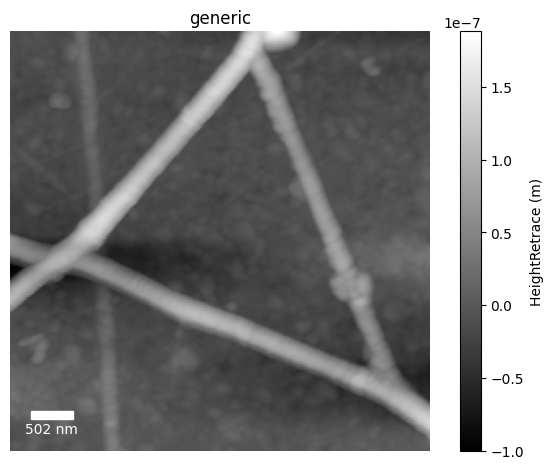

In [6]:
reader = IgorIBWReader(scan_file)
scan = reader.read()

topo = scan['Channel_000']

topo_scan = (topo.compute().T - topo.min()) *1e6 #um
xcenter = (topo.x.values[-1] / 2) * 1e6 #um
ycenter = (topo.y.values[-1] / 2) * 1e6 #um

fig = topo.plot(scale_bar=True, cmap='gray', origin='lower')

In [7]:
spectra = load_hdf5_to_dict(spectra_file)
sorted_spectra_v, sorted_spectra_l = sorted_lat_vert(spectra)

fit_res_v = fit_array(sorted_spectra_v,  d_ph=7, print_i=False)
fit_res_v[:,-1] = fit_res_v[:,-1]/np.pi*180

fit_res_l = fit_array(sorted_spectra_l,  d_ph=7, print_i=False)
fit_res_l[:,-1] = rotate_phase(fit_res_l[:,-1], -np.pi/2)/np.pi*180

/tmp/ipython-input-2870219628.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  opt, cov = curve_fit(amplitude_res, ar[0][~np.isnan(ar[0])], ar[1][~np.isnan(ar[0])], p0=p0, maxfev = int(2e4))


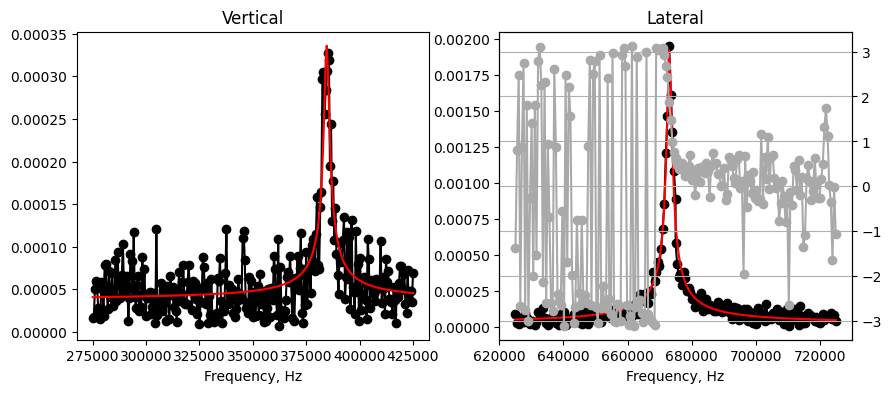

In [14]:
kk = -200

sp_v = sorted_spectra_v[kk]
sp_l = sorted_spectra_l[kk]

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*sp_v[:2], 'o-', c='k', label='experiment')
ax[0].plot(sp_v[0], amplitude_res(sp_v[0], *fit_res_v[kk,:-1]), c='r', label='fit')

# axx = ax[0].twinx()
# axx.plot(sp_v[0], sp_v[-1], 'o-', c='darkgray', label='experiment')

ax[1].plot(*sp_l[:2], 'o-', c='k', label='experiment')
ax[1].plot(sp_l[0], amplitude_res(sp_l[0], *fit_res_l[kk,:-1]), c='r', label='fit')

axx = ax[1].twinx()
axx.plot(sp_l[0], sp_l[-1], 'o-', c='darkgray', label='experiment')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Frequency, Hz')

plt.grid()

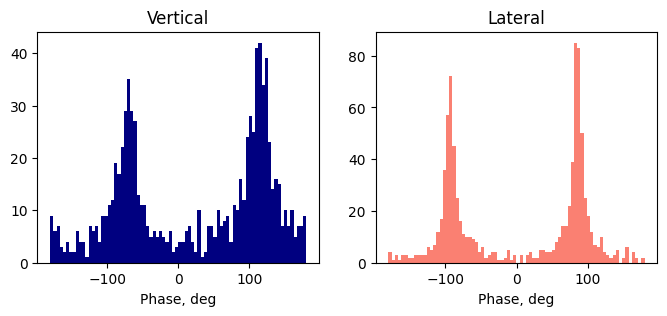

In [11]:
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(fit_res_v[:,-1], bins=80, color='navy')
ax[1].hist(fit_res_l[:,-1], bins=80, color='salmon')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Phase, deg')

Scalebar = 1500 nm


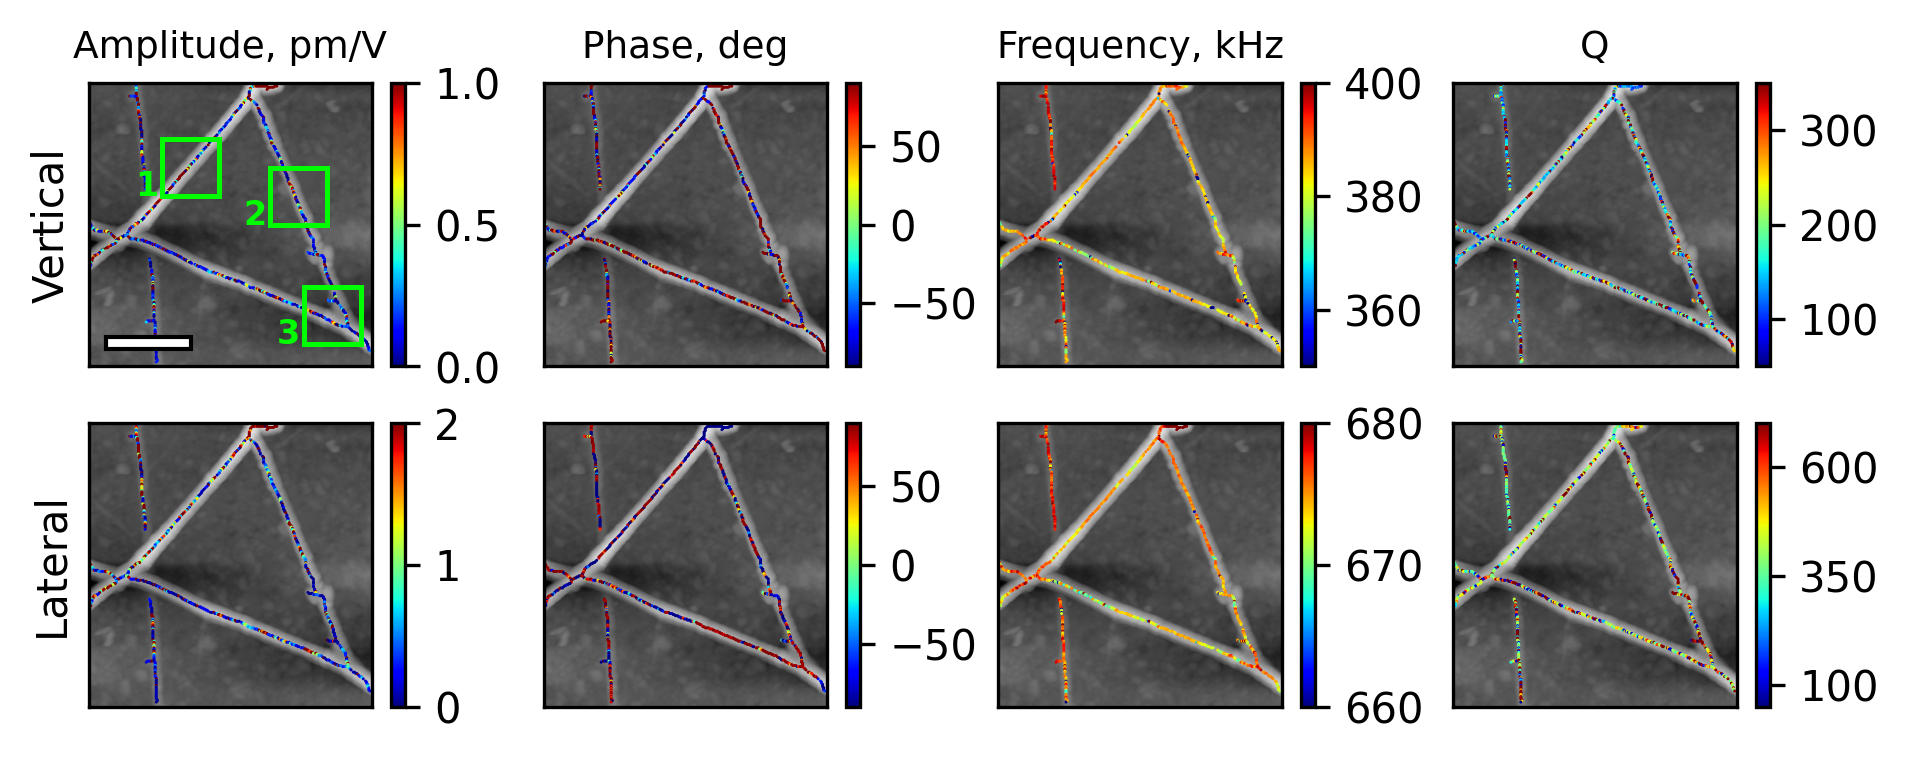

In [10]:
#@title Figure 2

import matplotlib.patches as patches

#--------colorbar------------
xmax = topo.x.values[-1]*1e6 #um
ymax = topo.x.values[-1]*1e6 #um

scalebar_length = 1.5 # um

rect = patches.Rectangle(
    (-2.2, -2.2),     # (x, y) - top-left corner
    scalebar_length, scalebar_length/7,       # width, height
    linewidth=1,
    edgecolor='k',
    facecolor='white')

#--------signals vert------------
dfl_invols = 133.03 #nm/V

amp_v = fit_res_v[:,0]*dfl_invols*1e3*2**.5
ph_v = fit_res_v[:,-1]
freq_v = fit_res_v[:,1]*1e-3
q_v = fit_res_v[:,2]

#--------signals lat------------
lat_invols = 156.06 #nm/V

amp_l = fit_res_l[:,0]*lat_invols*1e3*2**.5
ph_l = fit_res_l[:,-1]
freq_l = fit_res_l[:,1]*1e-3
q_l = fit_res_l[:,2]

#--------figure------------
fig, axx = plt.subplots(2,4, figsize=(7.5,2.7), dpi=300)

for _ in axx.flatten():
    im = _.imshow(topo_scan*1e3, origin='lower', cmap='gray', extent = [-xcenter, xcenter, -ycenter, ycenter])
    _.set_xticks([])
    _.set_yticks([])
    # _.set_xlim(-.25, .75)
    # _.set_ylim(-.75, .25)

#-----vertical-----
ax = axx[0]

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_v)].T*1e6, s=.5, c=amp_v[~np.isnan(amp_v)], cmap='jet', vmin=0, vmax=1, edgecolors='none')
plt.colorbar(sc, ax=ax[0])

sc = ax[1].scatter(*spectra['locations'][~np.isnan(amp_v)].T*1e6, s=.5, c=ph_v[~np.isnan(amp_v)], cmap='jet', vmin=-90, vmax=90, edgecolors='none')
plt.colorbar(sc, ax=ax[1])

sc = ax[2].scatter(*spectra['locations'][~np.isnan(amp_v)].T*1e6, s=.5, c=freq_v[~np.isnan(amp_v)], cmap='jet', vmin=350, vmax=400, edgecolors='none')
plt.colorbar(sc, ax=ax[2])

sc = ax[3].scatter(*spectra['locations'][~np.isnan(amp_v)].T*1e6, s=.5, c=abs(q_v[~np.isnan(amp_v)]), cmap='jet', vmax=350, vmin=50, edgecolors='none')
plt.colorbar(sc, ax=ax[3])

ax[0].add_patch(rect)

ax[0].set_title('Amplitude, pm/V', fontsize=9)
ax[1].set_title('Phase, deg', fontsize=9)
ax[2].set_title('Frequency, kHz', fontsize=9)
ax[3].set_title('Q', fontsize=9)

#-----lateral-----
ax = axx[1]

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_l)].T*1e6, s=.5, c=amp_l[~np.isnan(amp_l)], cmap='jet', vmin=0, vmax=2, edgecolors='none')
plt.colorbar(sc, ax=ax[0])

sc = ax[1].scatter(*spectra['locations'][~np.isnan(amp_l)].T*1e6, s=.5, c=ph_l[~np.isnan(amp_l)], cmap='jet', vmin=-90, vmax=90, edgecolors='none')
plt.colorbar(sc, ax=ax[1])

sc = ax[2].scatter(*spectra['locations'][~np.isnan(amp_l)].T*1e6, s=.5, c=freq_l[~np.isnan(amp_l)], cmap='jet', vmin=660, vmax=680, edgecolors='none')
plt.colorbar(sc, ax=ax[2])

sc = ax[3].scatter(*spectra['locations'][~np.isnan(amp_l)].T*1e6, s=.5, c=abs(q_l[~np.isnan(amp_l)]), cmap='jet', vmax=700, vmin=50, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.set_yticks([100, 350, 600])

#ax[0].add_patch(rect)

axx[0,0].set_ylabel('Vertical')
axx[1,0].set_ylabel('Lateral')


# Get reference to the first subplot
ax0 = axx[0,0]

# Compute total size from imshow extent
x_min, x_max = -xcenter, xcenter
y_min, y_max = -ycenter, ycenter

width = x_max - x_min
height = y_max - y_min

# Each square = 1/3 of image width/height
sq_size = width / 5

# Example positions (left, middle, right)
positions = [
    (x_min+1.3, y_min+3),                       # bottom-left
    (x_min + 3.2, y_min+2.5),             # middle
    (x_min + 3.8, y_min+.4)          # right
]

# Add the 3 green square outlines
for k,(x0, y0) in enumerate(positions):
    square = patches.Rectangle(
        (x0, y0), sq_size, sq_size,
        linewidth=1.2, edgecolor='lime', facecolor='none'
    )
    ax0.add_patch(square)

    ax0.text(
        x0 - .48, y0,
        str(k + 1),
        color='lime', fontsize=8, fontweight='bold'
    )


fig.savefig('fig2.jpg', dpi=300, bbox_inches='tight')

print(f'Scalebar = {int(scalebar_length*1000)} nm')




##

## KNN_0007 (Location 2)

In [15]:
#h5file
!gdown https://drive.google.com/file/d/1E0nY2rJPKXYZ0FKaLttaSP3iYvom_ToQ/view?usp=sharing --fuzzy
#ibw file
!gdown https://drive.google.com/file/d/1qWx4eKa8aq1uMLaGn2SSOlop24RowDSa/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1E0nY2rJPKXYZ0FKaLttaSP3iYvom_ToQ
To: /content/KNNN_0007.h5
100% 30.3M/30.3M [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qWx4eKa8aq1uMLaGn2SSOlop24RowDSa
To: /content/KNN_0007.ibw
100% 1.21M/1.21M [00:00<00:00, 117MB/s]


In [16]:
scan_file = 'KNN_0007.ibw'
spectra_file = 'KNNN_0007.h5'

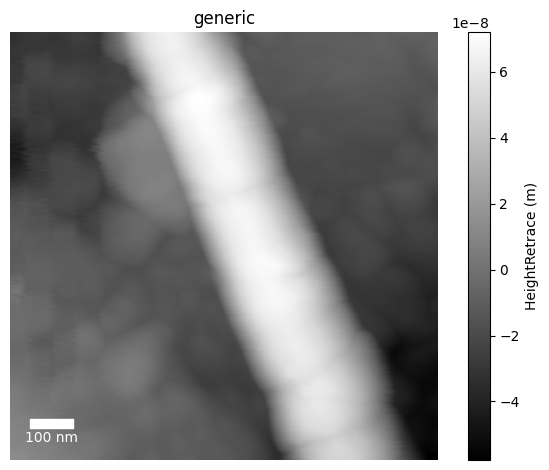

In [17]:
reader = IgorIBWReader(scan_file)
scan = reader.read()

topo = scan['Channel_000']

topo_scan = (topo.compute().T - topo.min()) *1e6 #um
xcenter = (topo.x.values[-1] / 2) * 1e6 #um
ycenter = (topo.y.values[-1] / 2) * 1e6 #um

fig = topo.plot(scale_bar=True, cmap='gray', origin='lower')

In [18]:
spectra = load_hdf5_to_dict(spectra_file)
sorted_spectra_v, sorted_spectra_l = sorted_lat_vert(spectra)

fit_res_v = fit_array(sorted_spectra_v,  d_ph=7, print_i=False)
fit_res_v[:,-1] = fit_res_v[:,-1]/np.pi*180

fit_res_l = fit_array(sorted_spectra_l,  d_ph=7, print_i=False)
fit_res_l[:,-1] = rotate_phase(fit_res_l[:,-1], -np.pi/2)/np.pi*180

/tmp/ipython-input-2870219628.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  opt, cov = curve_fit(amplitude_res, ar[0][~np.isnan(ar[0])], ar[1][~np.isnan(ar[0])], p0=p0, maxfev = int(2e4))


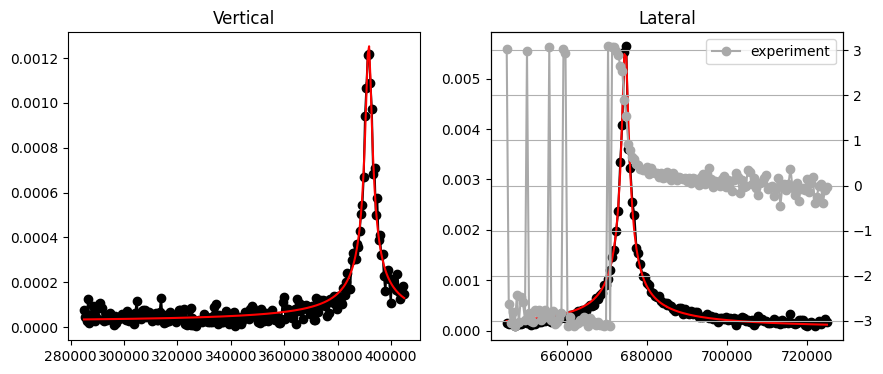

In [19]:
kk = -200

sp_v = sorted_spectra_v[kk]
sp_l = sorted_spectra_l[kk]

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*sp_v[:2], 'o-', c='k', label='experiment')
ax[0].plot(sp_v[0], amplitude_res(sp_v[0], *fit_res_v[kk,:-1]), c='r', label='fit')

# axx = ax[0].twinx()
# axx.plot(sp_v[0], sp_v[-1], 'o-', c='darkgray', label='experiment')

ax[1].plot(*sp_l[:2], 'o-', c='k', label='experiment')
ax[1].plot(sp_l[0], amplitude_res(sp_l[0], *fit_res_l[kk,:-1]), c='r', label='fit')

axx = ax[1].twinx()
axx.plot(sp_l[0], sp_l[-1], 'o-', c='darkgray', label='experiment')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

plt.grid()
plt.legend()

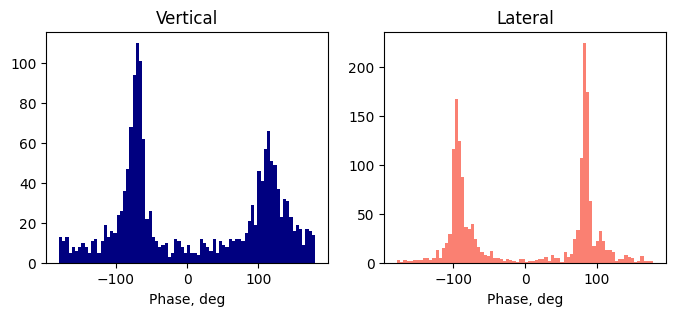

In [20]:
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(fit_res_v[:,-1], bins=80, color='navy')
ax[1].hist(fit_res_l[:,-1], bins=80, color='salmon')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Phase, deg')

Scalebar = 300 nm


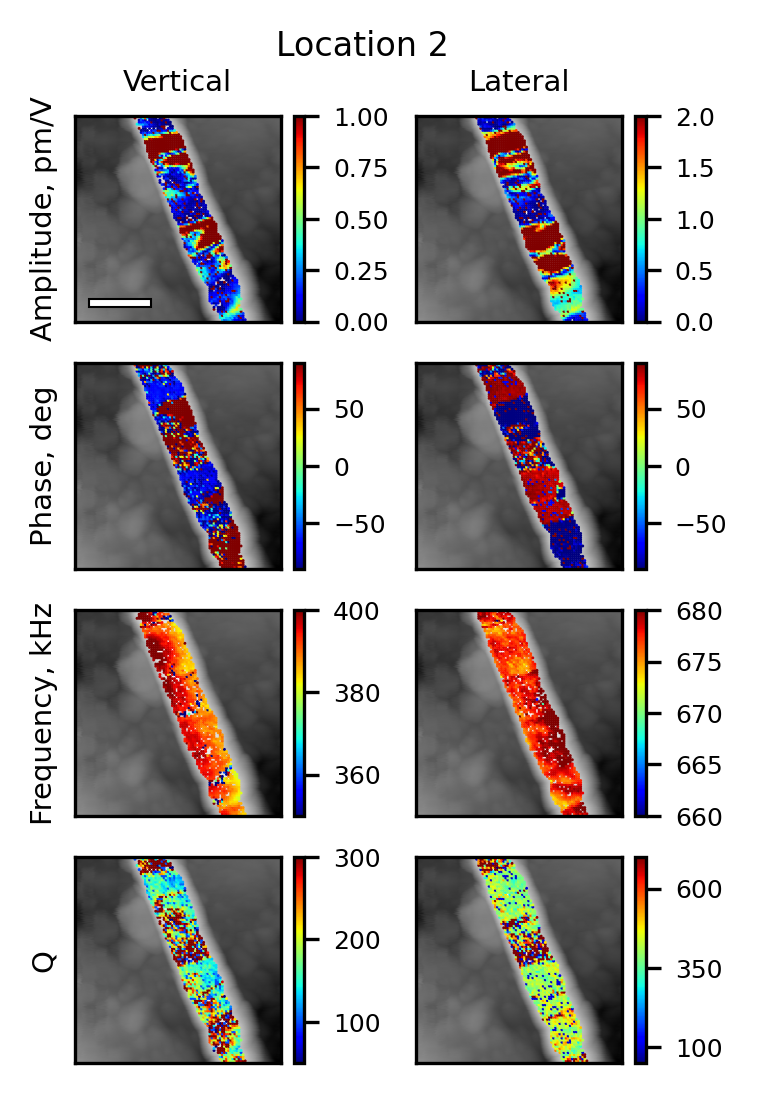

In [21]:
#@title Figure 3 (loc. 2)
import matplotlib.patches as patches

#--------colorbar------------
xmax = topo.x.values[-1]*1e6  # µm
ymax = topo.x.values[-1]*1e6  # µm

scalebar_length = 0.3  # µm

rect = patches.Rectangle(
    (-.43, -.43),              # (x, y)
    scalebar_length, scalebar_length / 7,  # width, height (horizontal bar)
    linewidth=.5,
    edgecolor='k',
    facecolor='white'
)

#--------signals vertical------------
dfl_invols = 133.03  # nm/V
amp_v = fit_res_v[:, 0] * dfl_invols * 1e3 * 2**0.5
ph_v = fit_res_v[:, -1]
freq_v = fit_res_v[:, 1] * 1e-3
q_v = fit_res_v[:, 2]

#--------signals lateral------------
lat_invols = 156.06  # nm/V
amp_l = fit_res_l[:, 0] * lat_invols * 1e3 * 2**0.5
ph_l = fit_res_l[:, -1]
freq_l = fit_res_l[:, 1] * 1e-3
q_l = fit_res_l[:, 2]

#--------figure------------
fig, axx = plt.subplots(4, 2, figsize=(2.6, 4.1), dpi=300)
fig.subplots_adjust(wspace=.3)

# Initialize background topography images
for _ in axx.flatten():
    im = _.imshow(
        topo_scan * 1e3,
        origin='lower',
        cmap='gray',
        extent=[-xcenter, xcenter, -ycenter, ycenter]
    )
    _.set_xticks([])
    _.set_yticks([])
    # _.set_xlim(-.25, .75)
    # _.set_ylim(-.25, .75)

#-----------------------------------
#          Vertical column
#-----------------------------------
ax = axx[:, 0]  # left column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_v)].T * 1e6,
                   s=0.5, c=amp_v[~np.isnan(amp_v)],
                   cmap='jet', vmin=0, vmax=1, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_v)].T * 1e6,
                   s=0.5, c=ph_v[~np.isnan(ph_v)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_v)].T * 1e6,
                   s=0.5, c=freq_v[~np.isnan(freq_v)],
                   cmap='jet', vmin=350, vmax=400, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_v)].T * 1e6,
                   s=0.5, c=np.abs(q_v[~np.isnan(q_v)]),
                   cmap='jet', vmin=50, vmax=300, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.tick_params(labelsize=6)

# Add scalebar to top-left plot
ax[0].add_patch(rect)

#-----------------------------------
#          Lateral column
#-----------------------------------
ax = axx[:, 1]  # right column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_l)].T * 1e6,
                   s=0.5, c=amp_l[~np.isnan(amp_l)],
                   cmap='jet', vmin=0, vmax=2, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=0.5, c=ph_l[~np.isnan(ph_l)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_l)].T * 1e6,
                   s=0.5, c=freq_l[~np.isnan(freq_l)],
                   cmap='jet', vmin=660, vmax=680, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_l)].T * 1e6,
                   s=0.5, c=np.abs(q_l[~np.isnan(q_l)]),
                   cmap='jet', vmin=50, vmax=700, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.set_yticks([100, 350, 600])
cbar.ax.tick_params(labelsize=6)

#-----------------------------------
#          Labels & Titles
#-----------------------------------
# Column titles
axx[0, 0].set_title('Vertical', fontsize=7)
axx[0, 1].set_title('Lateral', fontsize=7)

# Row labels (Y-axis descriptions)
row_labels = ['Amplitude, pm/V', 'Phase, deg', 'Frequency, kHz', 'Q']
for i, label in enumerate(row_labels):
    axx[i, 0].set_ylabel(label, fontsize=7)

fig.suptitle('Location 2', fontsize=8, y=0.95)

# Tight layout and save
#fig.tight_layout()
fig.savefig('loc2.jpg', dpi=300, bbox_inches='tight')

print(f'Scalebar = {int(scalebar_length * 1000)} nm')


In [22]:
ph_L = ph_l[~np.isnan(ph_l)]
ph_V = ph_v[~np.isnan(ph_v)]
ph_encode = (ph_V > 0).astype(int) * 2 + (ph_L > 0).astype(int)

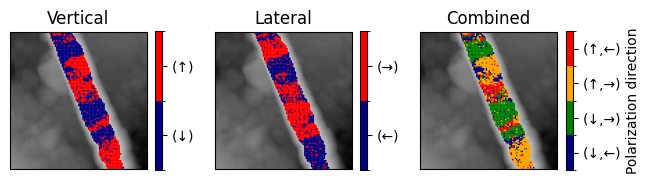

In [24]:
#@title Fig. 4 (loc. 2)
import matplotlib.colors as mcolors

# Discrete colormap for 4 labels
colors = ['navy', 'green', 'orange', 'red']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

colors1 = ['navy', 'red']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(1, 3,
                       figsize=(7.5,1.8),
                       gridspec_kw={'width_ratios': [1, 1, 1]})

for ax_ in ax:
  ax_.imshow(topo_scan*1e3, origin='lower', cmap='gray', extent = [-xcenter, xcenter, -ycenter, ycenter])
  ax_.set_xticks([])
  ax_.set_yticks([])



sc = ax[0].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_V,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[0],
             ticks=[0, 1],
             )

cbar.ax.set_yticklabels(['(↓)', '(↑)'], fontsize=10)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_L,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[1],
             ticks=[0, 1],
             )
cbar.ax.set_yticklabels(['(←)', '(→)'], fontsize=10)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_encode,
                   edgecolors='none',
                   cmap=cmap,
                   norm=norm,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[2],
             ticks=[0, 1, 2, 3],
             label='Polarization direction')

cbar.ax.set_yticklabels(['(↓,←)', '(↓,→)', '(↑,→)', '(↑,←)'], fontsize=10)

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')
ax[2].set_title('Combined')

fig.savefig('fig4.jpg', dpi=300, bbox_inches='tight')

## KNN_0009 (Location 1)

In [25]:
#h5file
!gdown https://drive.google.com/file/d/1AuSi-d0BPPVvNX1DrhoAovjNjWUTA43_/view?usp=sharing --fuzzy
#ibw file
!gdown https://drive.google.com/file/d/10valcM_pHv5U_mmYYjMeNwpXzkWSCScS/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1AuSi-d0BPPVvNX1DrhoAovjNjWUTA43_
To: /content/KNNN_0009.h5
100% 40.7M/40.7M [00:00<00:00, 49.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=10valcM_pHv5U_mmYYjMeNwpXzkWSCScS
To: /content/KNN_0009.ibw
100% 1.21M/1.21M [00:00<00:00, 39.3MB/s]


In [26]:
scan_file = 'KNN_0009.ibw'
spectra_file = 'KNNN_0009.h5'

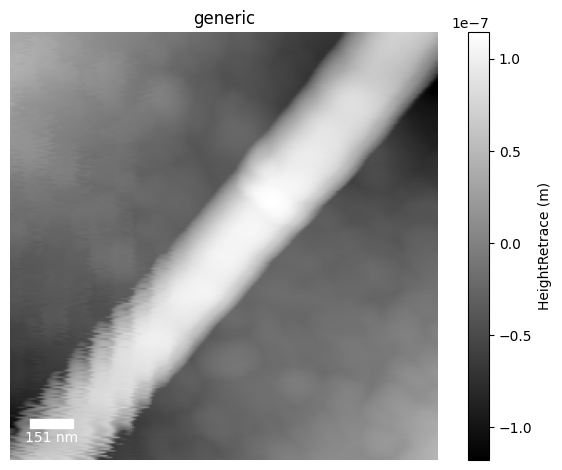

In [27]:
reader = IgorIBWReader(scan_file)
scan = reader.read()

topo = scan['Channel_000']

topo_scan = (topo.compute().T - topo.min()) *1e6 #um
xcenter = (topo.x.values[-1] / 2) * 1e6 #um
ycenter = (topo.y.values[-1] / 2) * 1e6 #um

fig = topo.plot(scale_bar=True, cmap='gray', origin='lower')

In [28]:
spectra = load_hdf5_to_dict(spectra_file)
sorted_spectra_v, sorted_spectra_l = sorted_lat_vert(spectra)

fit_res_v = fit_array(sorted_spectra_v,  d_ph=7, print_i=False)
fit_res_v[:,-1] = fit_res_v[:,-1]/np.pi*180

fit_res_l = fit_array(sorted_spectra_l,  d_ph=7, print_i=False)
fit_res_l[:,-1] = rotate_phase(fit_res_l[:,-1], -np.pi/2)/np.pi*180

/tmp/ipython-input-2870219628.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  opt, cov = curve_fit(amplitude_res, ar[0][~np.isnan(ar[0])], ar[1][~np.isnan(ar[0])], p0=p0, maxfev = int(2e4))


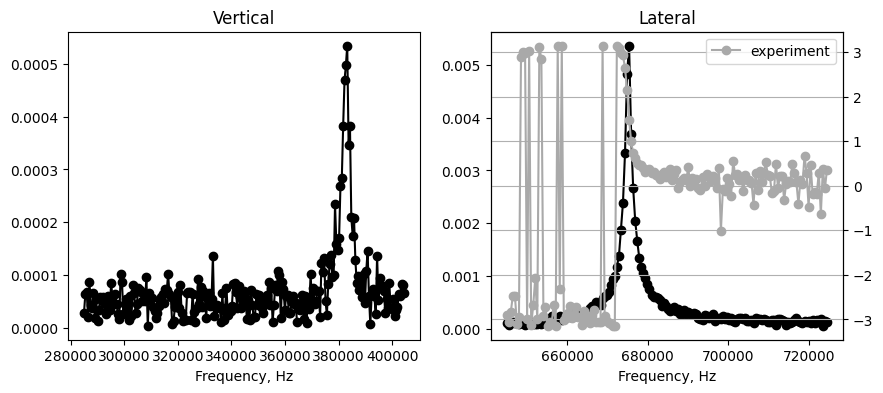

In [29]:
kk = -200

sp_v = sorted_spectra_v[kk]
sp_l = sorted_spectra_l[kk]

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*sp_v[:2], 'o-', c='k', label='experiment')
ax[0].plot(sp_v[0], amplitude_res(sp_v[0], *fit_res_v[kk,:-1]), c='r', label='fit')

# axx = ax[0].twinx()
# axx.plot(sp_v[0], sp_v[-1], 'o-', c='darkgray', label='experiment')

ax[1].plot(*sp_l[:2], 'o-', c='k', label='experiment')
ax[1].plot(sp_l[0], amplitude_res(sp_l[0], *fit_res_l[kk,:-1]), c='r', label='fit')

axx = ax[1].twinx()
axx.plot(sp_l[0], sp_l[-1], 'o-', c='darkgray', label='experiment')

for _ in ax:
  _.set_xlabel('Frequency, Hz')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

plt.grid()
plt.legend()


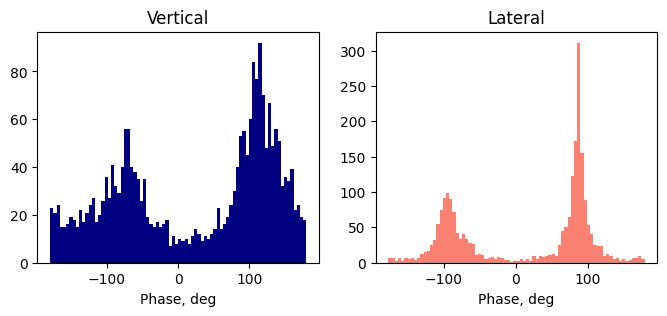

In [30]:
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(fit_res_v[:,-1], bins=80, color='navy')
ax[1].hist(fit_res_l[:,-1], bins=80, color='salmon')

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Phase, deg')

Scalebar = 300 nm


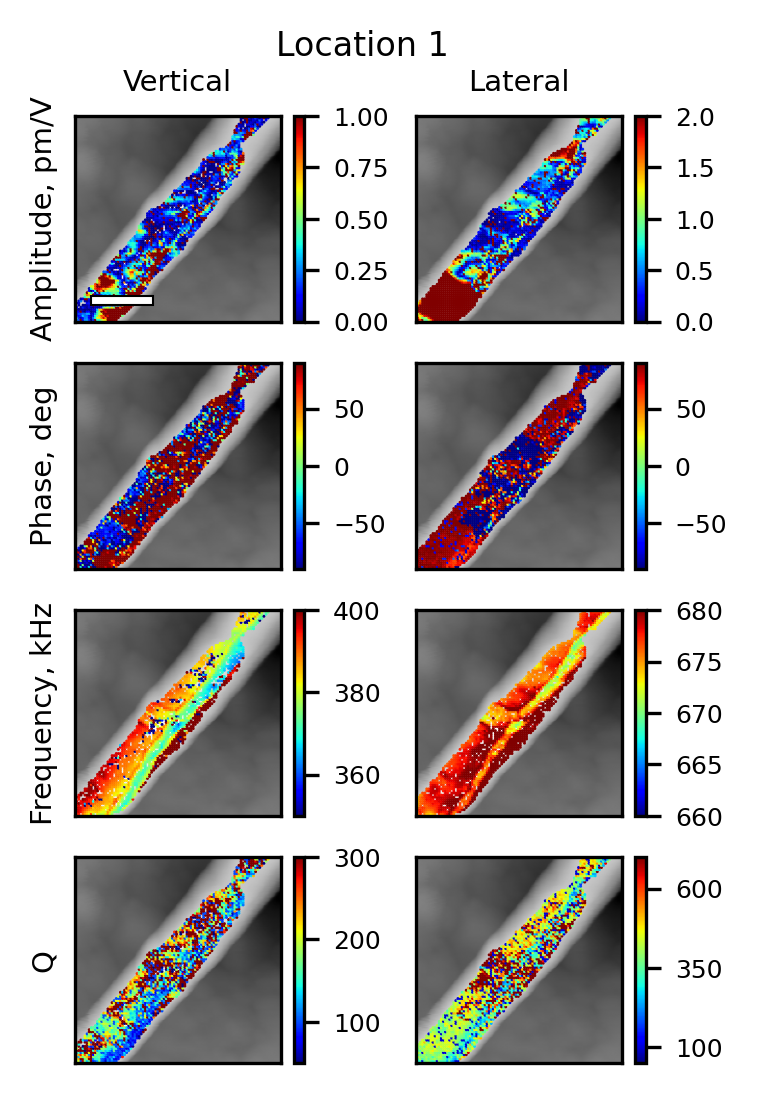

In [31]:
#@title Figure 3 (location 1)
import matplotlib.patches as patches

#--------colorbar------------
xmax = topo.x.values[-1]*1e6  # µm
ymax = topo.x.values[-1]*1e6  # µm

scalebar_length = 0.3  # µm

rect = patches.Rectangle(
    (-.17, -.17),              # (x, y)
    scalebar_length, scalebar_length / 7,  # width, height (horizontal bar)
    linewidth=.5,
    edgecolor='k',
    facecolor='white'
)

#--------signals vertical------------
dfl_invols = 133.03  # nm/V
amp_v = fit_res_v[:, 0] * dfl_invols * 1e3 * 2**0.5
ph_v = fit_res_v[:, -1]
freq_v = fit_res_v[:, 1] * 1e-3
q_v = fit_res_v[:, 2]

#--------signals lateral------------
lat_invols = 156.06  # nm/V
amp_l = fit_res_l[:, 0] * lat_invols * 1e3 * 2**0.5
ph_l = fit_res_l[:, -1]
freq_l = fit_res_l[:, 1] * 1e-3
q_l = fit_res_l[:, 2]

#--------figure------------
fig, axx = plt.subplots(4, 2, figsize=(2.6, 4.1), dpi=300)
fig.subplots_adjust(wspace=.3)

# Initialize background topography images
for _ in axx.flatten():
    im = _.imshow(
        topo_scan * 1e3,
        origin='lower',
        cmap='gray',
        extent=[-xcenter, xcenter, -ycenter, ycenter]
    )
    _.set_xticks([])
    _.set_yticks([])
    _.set_xlim(-.25, .75)
    _.set_ylim(-.25, .75)

#-----------------------------------
#          Vertical column
#-----------------------------------
ax = axx[:, 0]  # left column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_v)].T * 1e6,
                   s=0.5, c=amp_v[~np.isnan(amp_v)],
                   cmap='jet', vmin=0, vmax=1, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_v)].T * 1e6,
                   s=0.5, c=ph_v[~np.isnan(ph_v)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_v)].T * 1e6,
                   s=0.5, c=freq_v[~np.isnan(freq_v)],
                   cmap='jet', vmin=350, vmax=400, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_v)].T * 1e6,
                   s=0.5, c=np.abs(q_v[~np.isnan(q_v)]),
                   cmap='jet', vmin=50, vmax=300, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.tick_params(labelsize=6)

# Add scalebar to top-left plot
ax[0].add_patch(rect)

#-----------------------------------
#          Lateral column
#-----------------------------------
ax = axx[:, 1]  # right column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_l)].T * 1e6,
                   s=0.5, c=amp_l[~np.isnan(amp_l)],
                   cmap='jet', vmin=0, vmax=2, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=0.5, c=ph_l[~np.isnan(ph_l)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_l)].T * 1e6,
                   s=0.5, c=freq_l[~np.isnan(freq_l)],
                   cmap='jet', vmin=660, vmax=680, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_l)].T * 1e6,
                   s=0.5, c=np.abs(q_l[~np.isnan(q_l)]),
                   cmap='jet', vmin=50, vmax=700, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.set_yticks([100, 350, 600])
cbar.ax.tick_params(labelsize=6)

#-----------------------------------
#          Labels & Titles
#-----------------------------------
# Column titles
axx[0, 0].set_title('Vertical', fontsize=7)
axx[0, 1].set_title('Lateral', fontsize=7)

# Row labels (Y-axis descriptions)
row_labels = ['Amplitude, pm/V', 'Phase, deg', 'Frequency, kHz', 'Q']
for i, label in enumerate(row_labels):
    axx[i, 0].set_ylabel(label, fontsize=7)

fig.suptitle('Location 1', fontsize=8, y=0.95)

# Tight layout and save
#fig.tight_layout()
fig.savefig('loc1.jpg', dpi=300, bbox_inches='tight')

print(f'Scalebar = {int(scalebar_length * 1000)} nm')


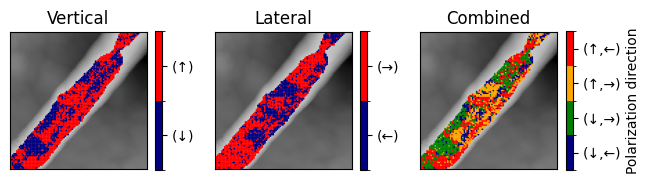

In [32]:
#@title Figure 4 (Location 1)

import matplotlib.colors as mcolors

ph_L = ph_l[~np.isnan(ph_l)]
ph_V = ph_v[~np.isnan(ph_v)]
ph_encode = (ph_V > 0).astype(int) * 2 + (ph_L > 0).astype(int)



# Discrete colormap for 4 labels
colors = ['navy', 'green', 'orange', 'red']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

colors1 = ['navy', 'red']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(1, 3,
                       figsize=(7.5,1.8),
                       gridspec_kw={'width_ratios': [1, 1, 1]})

for ax_ in ax:
  ax_.imshow(topo_scan*1e3, origin='lower', cmap='gray', extent = [-xcenter, xcenter, -ycenter, ycenter])
  ax_.set_xticks([])
  ax_.set_yticks([])
  ax_.set_xlim(-.25, .75)
  ax_.set_ylim(-.25, .75)



sc = ax[0].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_V,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[0],
             ticks=[0, 1],
             )

cbar.ax.set_yticklabels(['(↓)', '(↑)'], fontsize=10)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_L,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[1],
             ticks=[0, 1],
             )
cbar.ax.set_yticklabels(['(←)', '(→)'], fontsize=10)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_encode,
                   edgecolors='none',
                   cmap=cmap,
                   norm=norm,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[2],
             ticks=[0, 1, 2, 3],
             label='Polarization direction')

cbar.ax.set_yticklabels(['(↓,←)', '(↓,→)', '(↑,→)', '(↑,←)'], fontsize=10)

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')
ax[2].set_title('Combined')

fig.savefig('fig4_3.jpg', dpi=300, bbox_inches='tight')

## KNN_0012 (Location 3)

In [33]:
#h5file
!gdown https://drive.google.com/file/d/14_-PF4MSc5IhY3NXrDyyQp6wJdO4VPLF/view?usp=sharing --fuzzy
#ibw file
!gdown https://drive.google.com/file/d/1HWjY0Fb3tfiFRvXkPUaA2oTkwbPtsdWQ/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=14_-PF4MSc5IhY3NXrDyyQp6wJdO4VPLF
To: /content/KNNN_0012.h5
100% 67.3M/67.3M [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HWjY0Fb3tfiFRvXkPUaA2oTkwbPtsdWQ
To: /content/KNN_0012.ibw
100% 1.21M/1.21M [00:00<00:00, 79.4MB/s]


In [34]:
scan_file = 'KNN_0012.ibw'
spectra_file = 'KNNN_0012.h5'

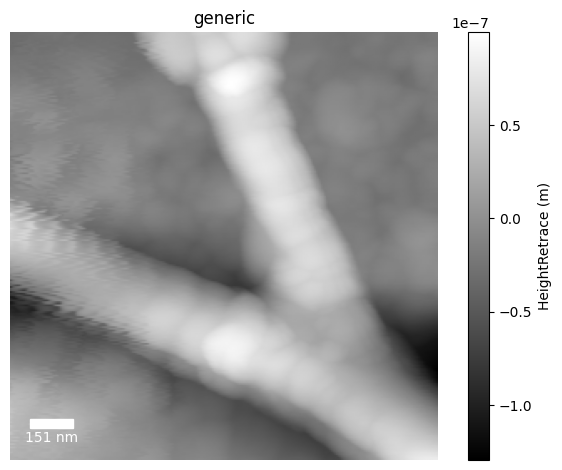

In [35]:
reader = IgorIBWReader(scan_file)
scan = reader.read()

topo = scan['Channel_000']

topo_scan = (topo.compute().T - topo.min()) *1e6 #um
xcenter = (topo.x.values[-1] / 2) * 1e6 #um
ycenter = (topo.y.values[-1] / 2) * 1e6 #um

fig = topo.plot(scale_bar=True, cmap='gray', origin='lower')

In [36]:
spectra = load_hdf5_to_dict(spectra_file)
sorted_spectra_v, sorted_spectra_l = sorted_lat_vert(spectra)

fit_res_v = fit_array(sorted_spectra_v,  d_ph=7, print_i=False)
fit_res_v[:,-1] = fit_res_v[:,-1]/np.pi*180

fit_res_l = fit_array(sorted_spectra_l,  d_ph=7, print_i=False)
fit_res_l[:,-1] = rotate_phase(fit_res_l[:,-1], -np.pi/2)/np.pi*180

/tmp/ipython-input-2870219628.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  opt, cov = curve_fit(amplitude_res, ar[0][~np.isnan(ar[0])], ar[1][~np.isnan(ar[0])], p0=p0, maxfev = int(2e4))


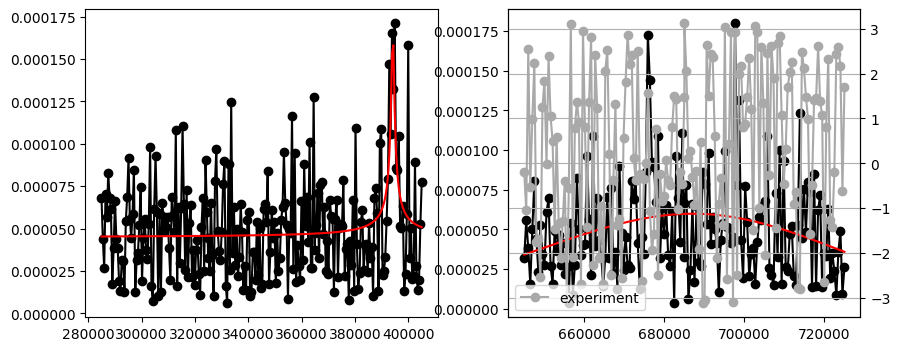

In [37]:
kk = -200

sp_v = sorted_spectra_v[kk]
sp_l = sorted_spectra_l[kk]

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*sp_v[:2], 'o-', c='k', label='experiment')
ax[0].plot(sp_v[0], amplitude_res(sp_v[0], *fit_res_v[kk,:-1]), c='r', label='fit')

# axx = ax[0].twinx()
# axx.plot(sp_v[0], sp_v[-1], 'o-', c='darkgray', label='experiment')

ax[1].plot(*sp_l[:2], 'o-', c='k', label='experiment')
ax[1].plot(sp_l[0], amplitude_res(sp_l[0], *fit_res_l[kk,:-1]), c='r', label='fit')

axx = ax[1].twinx()
axx.plot(sp_l[0], sp_l[-1], 'o-', c='darkgray', label='experiment')

ax[0].set_title('Vertical')
ax[0].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Frequency, Hz')

plt.grid()
plt.legend()

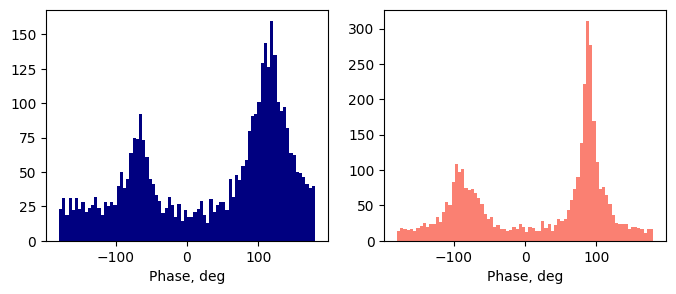

In [38]:
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].hist(fit_res_v[:,-1], bins=80, color='navy')
ax[1].hist(fit_res_l[:,-1], bins=80, color='salmon')

ax[0].set_title('Vertical')
ax[0].set_title('Lateral')

for _ in ax:
  _.set_xlabel('Phase, deg')




Scalebar = 300 nm


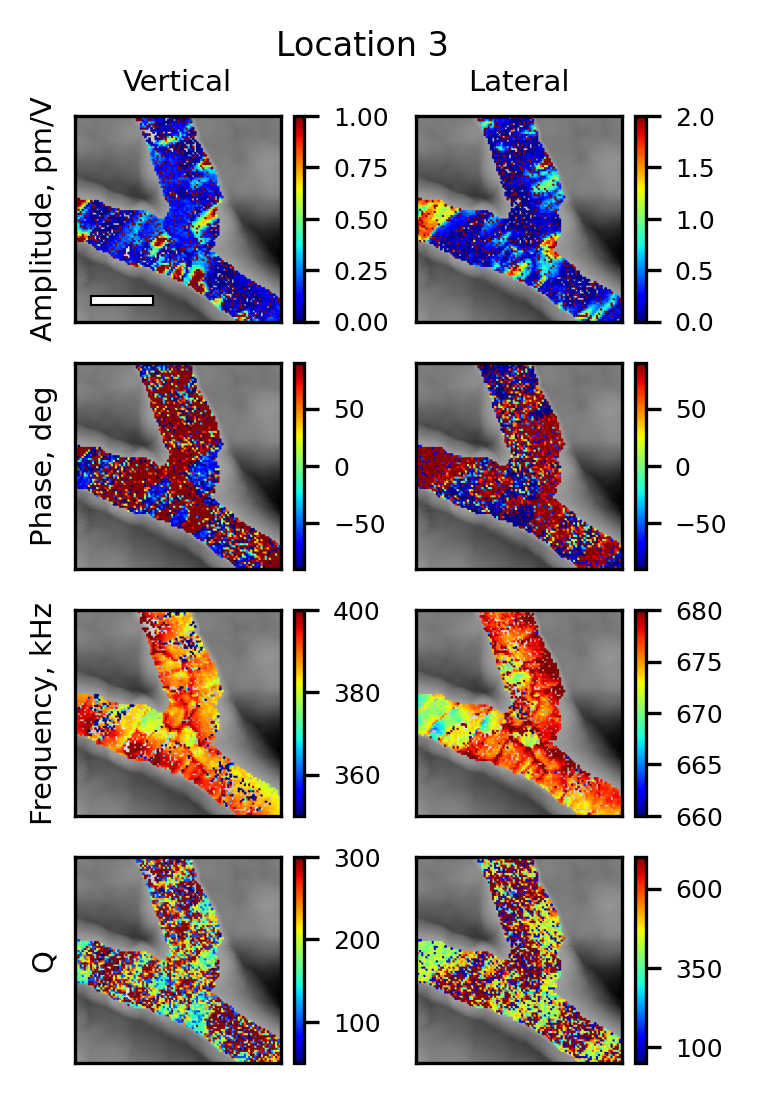

In [39]:
#@title Figure 3 (Location 1)
import matplotlib.patches as patches

#--------colorbar------------
xmax = topo.x.values[-1]*1e6  # µm
ymax = topo.x.values[-1]*1e6  # µm

scalebar_length = 0.3  # µm

rect = patches.Rectangle(
    (-0.17, -0.67),              # (x, y)
    scalebar_length, scalebar_length / 7,  # width, height (horizontal bar)
    linewidth=.5,
    edgecolor='k',
    facecolor='white'
)

#--------signals vertical------------
dfl_invols = 133.03  # nm/V
amp_v = fit_res_v[:, 0] * dfl_invols * 1e3 * 2**0.5
ph_v = fit_res_v[:, -1]
freq_v = fit_res_v[:, 1] * 1e-3
q_v = fit_res_v[:, 2]

#--------signals lateral------------
lat_invols = 156.06  # nm/V
amp_l = fit_res_l[:, 0] * lat_invols * 1e3 * 2**0.5
ph_l = fit_res_l[:, -1]
freq_l = fit_res_l[:, 1] * 1e-3
q_l = fit_res_l[:, 2]

#--------figure------------
fig, axx = plt.subplots(4, 2, figsize=(2.6, 4.1), dpi=300)
fig.subplots_adjust(wspace=.3)

# Initialize background topography images
for _ in axx.flatten():
    im = _.imshow(
        topo_scan * 1e3,
        origin='lower',
        cmap='gray',
        extent=[-xcenter, xcenter, -ycenter, ycenter]
    )
    _.set_xticks([])
    _.set_yticks([])
    _.set_xlim(-0.25, 0.75)
    _.set_ylim(-0.75, 0.25)

#-----------------------------------
#          Vertical column
#-----------------------------------
ax = axx[:, 0]  # left column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_v)].T * 1e6,
                   s=0.5, c=amp_v[~np.isnan(amp_v)],
                   cmap='jet', vmin=0, vmax=1, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_v)].T * 1e6,
                   s=0.5, c=ph_v[~np.isnan(ph_v)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_v)].T * 1e6,
                   s=0.5, c=freq_v[~np.isnan(freq_v)],
                   cmap='jet', vmin=350, vmax=400, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_v)].T * 1e6,
                   s=0.5, c=np.abs(q_v[~np.isnan(q_v)]),
                   cmap='jet', vmin=50, vmax=300, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.tick_params(labelsize=6)

# Add scalebar to top-left plot
ax[0].add_patch(rect)

#-----------------------------------
#          Lateral column
#-----------------------------------
ax = axx[:, 1]  # right column

sc = ax[0].scatter(*spectra['locations'][~np.isnan(amp_l)].T * 1e6,
                   s=0.5, c=amp_l[~np.isnan(amp_l)],
                   cmap='jet', vmin=0, vmax=2, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[0])
cbar.ax.tick_params(labelsize=6)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=0.5, c=ph_l[~np.isnan(ph_l)],
                   cmap='jet', vmin=-90, vmax=90, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[1])
cbar.ax.tick_params(labelsize=6)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(freq_l)].T * 1e6,
                   s=0.5, c=freq_l[~np.isnan(freq_l)],
                   cmap='jet', vmin=660, vmax=680, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[2])
cbar.ax.tick_params(labelsize=6)

sc = ax[3].scatter(*spectra['locations'][~np.isnan(q_l)].T * 1e6,
                   s=0.5, c=np.abs(q_l[~np.isnan(q_l)]),
                   cmap='jet', vmin=50, vmax=700, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax[3])
cbar.ax.set_yticks([100, 350, 600])
cbar.ax.tick_params(labelsize=6)

#-----------------------------------
#          Labels & Titles
#-----------------------------------
# Column titles
axx[0, 0].set_title('Vertical', fontsize=7)
axx[0, 1].set_title('Lateral', fontsize=7)

# Row labels (Y-axis descriptions)
row_labels = ['Amplitude, pm/V', 'Phase, deg', 'Frequency, kHz', 'Q']
for i, label in enumerate(row_labels):
    axx[i, 0].set_ylabel(label, fontsize=7)

fig.suptitle('Location 3', fontsize=8, y=0.95)

# Tight layout and save
#fig.tight_layout()
fig.savefig('loc3.jpg', dpi=300, bbox_inches='tight')

print(f'Scalebar = {int(scalebar_length * 1000)} nm')


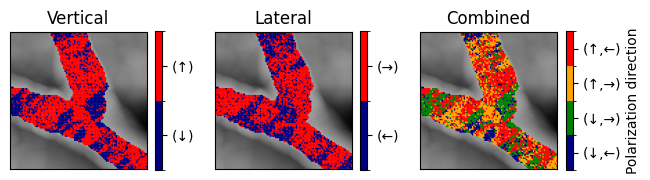

In [40]:
#@title Figure 4 (loc. 3)

import matplotlib.colors as mcolors

ph_L = ph_l[~np.isnan(ph_l)]
ph_V = ph_v[~np.isnan(ph_v)]
ph_encode = (ph_V > 0).astype(int) * 2 + (ph_L > 0).astype(int)



# Discrete colormap for 4 labels
colors = ['navy', 'green', 'orange', 'red']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

colors1 = ['navy', 'red']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(1, 3,
                       figsize=(7.5,1.8),
                       gridspec_kw={'width_ratios': [1, 1, 1]})

for ax_ in ax:
  ax_.imshow(topo_scan*1e3, origin='lower', cmap='gray', extent = [-xcenter, xcenter, -ycenter, ycenter])
  ax_.set_xticks([])
  ax_.set_yticks([])
  ax_.set_xlim(-0.25, 0.75)
  ax_.set_ylim(-0.75, 0.25)



sc = ax[0].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_V,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[0],
             ticks=[0, 1],
             )

cbar.ax.set_yticklabels(['(↓)', '(↑)'], fontsize=10)

sc = ax[1].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_L,
                   edgecolors='none',
                   cmap=cmap1,
                   norm=norm1,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[1],
             ticks=[0, 1],
             )
cbar.ax.set_yticklabels(['(←)', '(→)'], fontsize=10)

sc = ax[2].scatter(*spectra['locations'][~np.isnan(ph_l)].T * 1e6,
                   s=2, c=ph_encode,
                   edgecolors='none',
                   cmap=cmap,
                   norm=norm,
                   lw=0)
cbar = plt.colorbar(sc, ax=ax[2],
             ticks=[0, 1, 2, 3],
             label='Polarization direction')

cbar.ax.set_yticklabels(['(↓,←)', '(↓,→)', '(↑,→)', '(↑,←)'], fontsize=10)

ax[0].set_title('Vertical')
ax[1].set_title('Lateral')
ax[2].set_title('Combined')

fig.savefig('fig4_2.jpg', dpi=300, bbox_inches='tight')